In [1]:
import pandas as pd
import nlp.sanitize as st
import nlp.embedding as eb
import numpy as np
import yaml
%load_ext autoreload
%autoreload 2

In [2]:

conf_file = open('./conf/gender_train.yaml')
gender_conf = yaml.load(conf_file)
print(gender_conf)

{'text': {'type': 'csv', 'path': './data/gender_tweet.csv', 'text_column': 'text', 'label_column': 'gender'}, 'embedding': {'path': './data/GoogleNews-vectors-negative300-SLIM.bin.gz', 'sequence_length': 100, 'embed_size': 300}}


In [3]:
print(gender_conf)

text_conf = gender_conf['text']
data = pd.read_csv(text_conf['path'], encoding='latin1')
data = st.standardize(data, text_conf['text_column'])

texts = {}
genders = {}

for id, text, gender in zip(data['_unit_id'], data['tokens'], data['gender']):
    prev_text = texts.get(id, [])
    texts[id] = prev_text + text
    if genders.get(gender) is None:
        genders[id] = gender
    elif genders[id] != gender:
        print(id)

lengths = np.array([len(value) for _, value in texts.items()])
print(np.histogram(lengths))
print(np.max(lengths))
print(len(lengths))


{'text': {'type': 'csv', 'path': './data/gender_tweet.csv', 'text_column': 'text', 'label_column': 'gender'}, 'embedding': {'path': './data/GoogleNews-vectors-negative300-SLIM.bin.gz', 'sequence_length': 100, 'embed_size': 300}}
(array([6538, 9846, 3620,   44,    0,    0,    1,    0,    0,    1]), array([  1. ,  11.4,  21.8,  32.2,  42.6,  53. ,  63.4,  73.8,  84.2,
        94.6, 105. ]))
105
20050


In [4]:
import pickle
file=open('./data/profile_images.pik', 'rb')
profile_images = pickle.load(file)
file.close()

In [9]:
from PIL import Image
from io import BytesIO

# print(profile_images[0])


for id, image in profile_images.items():
    img_bytes=BytesIO(image)
    img = Image.open(img_bytes)
    a = np.array(img, dtype=np.int32)
    print(a[20])
    print(id)
    img.show()
    print(a.shape)
    break
    

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 9 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
815726592
(48, 48)


In [5]:
for i, sentence in enumerate(texts):
    if i<5:
        print(sentence)

815726592
815726593
815726594
815726595
815726596


In [6]:
gender_mapping={
    'unknown':0,
    'male':1,
    'female':2,
    'brand':3,
}

In [7]:
labels = np.zeros_like(genders)

In [8]:
for idx, val in enumerate(genders):
    if val in gender_mapping:
        labels[idx]=gender_mapping[val]
    else:
        labels[idx]=0

In [9]:
tokens = st.standardize(data, 'text')

embeddings = eb.get_word2vec_embeddings(tokens)

Start to loading word2vec model....


In [10]:
eb.dump_embeddings('./data/gender_embeddings', embeddings)

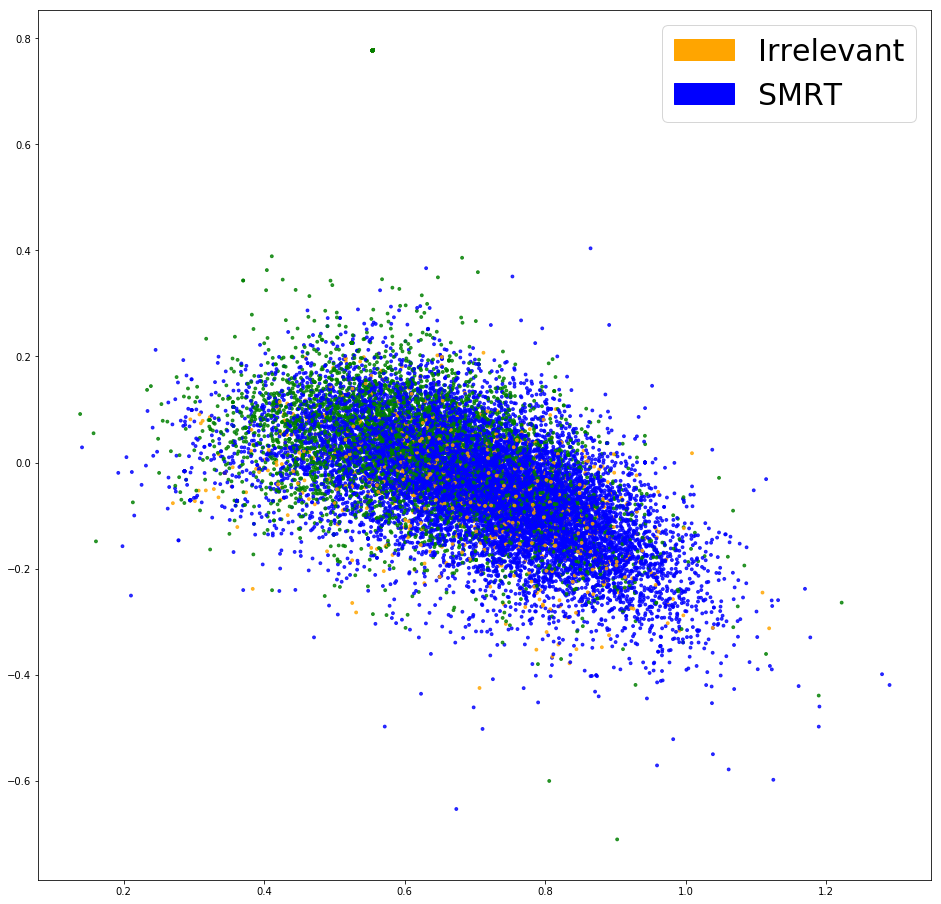

In [12]:
import nlp.lsa as lsa

embeddings=eb.load_embeddings('./data/gender_embeddings')
fig = lsa.plt.figure(figsize=(16, 16))
lsa.plot_lsa(embeddings, labels)
lsa.plt.show()

In [12]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=40)

In [13]:
X_train = np.array(X_train)
y_train = np.array(y_train, dtype=int)
print(X_train.shape)
print(y_train.shape)


(16040, 300)
(16040,)


In [14]:
from sklearn.linear_model import LogisticRegression

clf_w2v = LogisticRegression()
clf_w2v.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
y_pred=clf_w2v.predict(X_test)
y_train_pred=clf_w2v.predict(X_train)

print(np.mean(y_train==y_train_pred))
print(np.mean(y_pred==y_test))

0.5399625935162095
0.5291770573566085


In [17]:
from sklearn.svm import LinearSVC
svm_w2v = LinearSVC()
svm_w2v.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [18]:
y_pred=svm_w2v.predict(X_test)
y_train_pred=svm_w2v.predict(X_train)

print(np.mean(y_train==y_train_pred))
print(np.mean(y_pred==y_test))

0.5380299251870324
0.5259351620947631
